<a href="https://colab.research.google.com/github/JuanM-GG/maestria/blob/main/ml-lote/time_stepper_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install smt

In [ ]:
pip install torchdyn

In [ ]:
pip install pyDOE

In [5]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np

import torch
from torchdyn.numerics import odeint
# from torchdyn.numerics.solvers import SolverTemplate
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

from visualization import get_meshgrid, plot_colored

### Solvers

In [15]:
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass


class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None

class ResnetSolver(SolverTemplate):
    def __init__(self, step_size=None, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

        self.step_size = 1 if step_size is None else step_size

    def step(self, f, x, t, dt, k1=None, args=None):
        # x_sol = f(t, x)
        x_sol = x + f(t, x) * self.step_size
        return None, x_sol, None

### Generate data

In [7]:
# generate data

def f(t, x):
    θ = x[..., 0]
    ω = x[..., 1]

    dθ = ω
    dω = -torch.sin(θ)

    return torch.stack((dθ, dω), dim=-1)

domain_draw_factor = 1.3

domain_train = 1.0
domain_validate = 1.0

x0_train = (
    torch.tensor(lhs(2, 100), device='cpu') * 2 - 1
) * domain_train

x0_validate = (
    torch.tensor(lhs(2, 10), device='cpu') * 2 - 1
) * domain_validate

x0_grid = get_meshgrid(step_per_axis=0.01, domain=domain_validate)
x0_example = torch.tensor((0.6, 0)).double().unsqueeze(0).to('cpu')

step_size_train = 0.001
ε = 1e-10
t_span_train = torch.arange(
    0.0,0.001 + ε, step_size_train
)
t_span_validate = torch.arange(
    0.0,
    4*np.pi + ε,
    step_size_train,
)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/visualization.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  return xy.T


In [16]:
solver = ResnetSolver()

In [9]:
_, x_train = odeint(f, x0_train, t_span_train, solver="rk4")
x_true = x_train
x_train = x_train + torch.randn_like(x_train) * 0.0

_, x_validate = odeint(f, x0_validate, t_span_validate, solver="rk4")
_, x_example = odeint(f, x0_example, t_span_validate, solver="rk4")

In [10]:
_, x_validate = odeint(f, x0_validate, t_span_validate, solver="rk4")
_, x_example = odeint(f, x0_example, t_span_validate, solver="rk4")

### Model

In [11]:
##################### model ##########################
layers = []
layers.append(nn.Linear(2, 32))
for _ in range(8):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.Softplus())

layers.append(nn.Linear(32, 2))

net = nn.Sequential(*layers)
net.to('cpu').double()

for m in net.modules():
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

### Training

In [12]:
# optimizer

opt = Adam(net.parameters())

# train
losses = []

In [14]:
solver

ResnetSolver()

In [17]:
for _ in tqdm(range(2000)):

    _, x_pred_train = odeint(
        lambda t, x: net(x), 
        x0_train,
        t_span_train, 
        solver=solver
    )
    
    loss = mse_loss(x_pred_train, x_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

100%|██████████| 2000/2000 [00:07<00:00, 250.12it/s]


### Validation

In [18]:
_, x_pred_train = odeint(lambda t, x: net(x), x0_train, t_span_train, solver=solver)

In [19]:
_, x_pred_validate = odeint(
    lambda t, x: net(x), x0_validate, t_span_validate, solver=solver
)

In [20]:
_, x_pred_example = odeint(
    lambda t, x: net(x), x0_example, t_span_validate, solver=solver
)

In [21]:
# derivatives
# x0_grid_before = get_meshgrid(step_per_axis=0.01, domain=domain)
x_derivative = f(None, x0_grid)

Direct

In [22]:
out = net(x0_grid)
# normalize for the step size used during training. If the network is trained with a step-size of 1/100 of a second
# it will predict changes that are 100 times as small as those for 1 second.
x_derivative_pred = (out - x0_grid) / step_size_train

In [23]:
print(type(x_derivative_pred))

<class 'torch.Tensor'>


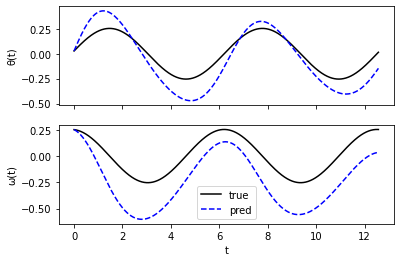

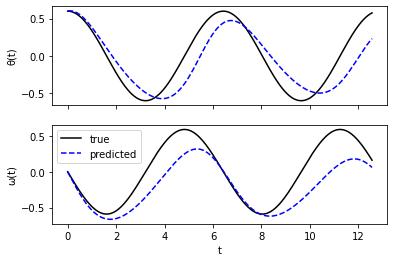

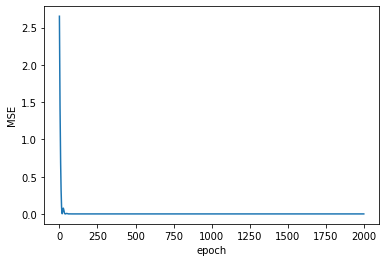

In [24]:
 # @title plot
try:
    x_pred_train = x_pred_train.detach().numpy()
    x_pred_validate = x_pred_validate.detach().numpy()
    x_pred_example = x_pred_example.detach().numpy()
    x_derivative_pred = x_derivative_pred.detach().numpy()
    x_derivative = x_derivative.detach().numpy()
    x0_grid = x0_grid.detach().numpy()


    # time series validation, specific idx
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    example_idx = 0

    ax1.plot(t_span_validate, x_validate[..., example_idx, 0], color="black")
    ax1.plot(
        t_span_validate,
        x_pred_validate[..., example_idx, 0],
        linestyle="dashed",
        color="blue",
    )
    ax2.plot(
        t_span_validate, x_validate[..., example_idx, 1], color="black", label="true"
    )
    ax2.plot(
        t_span_validate,
        x_pred_validate[..., example_idx, 1],
        linestyle="dashed",
        color="blue",
        label="pred",
    )
    ax1.set_ylabel("θ(t)")
    ax2.set_ylabel("ω(t)")
    ax2.set_xlabel("t")
    ax2.legend()

    # time series validation, example (0.6,0)
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.canvas.manager.set_window_title(f"states vs time: validation example")

    ax1.plot(t_span_validate, x_example[..., 0], color="black")
    ax1.plot(
        t_span_validate,
        x_pred_example[..., 0],
        linestyle="dashed",
        color="blue",
    )
    ax2.plot(t_span_validate, x_example[..., 1], label="true", color="black")
    ax2.plot(
        t_span_validate,
        x_pred_example[..., 1],
        linestyle="dashed",
        color="blue",
        label="predicted",
    )
    ax1.set_ylabel("θ(t)")
    ax2.set_ylabel("ω(t)")
    ax2.set_xlabel("t")
    ax2.legend()

    # show
    fig, ax = plt.subplots()
    ax.plot(losses)
    ax.set_xlabel("epoch")
    ax.set_ylabel("MSE")

    plt.show()

except:
    pass